<a href="https://colab.research.google.com/github/mcurcio5/OOTM-Option-Pricing-with-Power-Laws-and-News/blob/master/alpha_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive to Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab/Eric/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd drive/My\ Drive/$FOLDERNAME

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab/Eric


In [2]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=e811bf40438da8900cf05a9f5e92c3383960b3eea01812b05ba6a3b01c4f2db0
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import random
from scipy.special import zeta
from scipy.optimize import bisect
from datetime import datetime, timedelta

I will start by defining functions that use MLE methods to find the $\alpha$ parameter for power law distributions. Note, that these methods are for continuous power law distributions.

a_lower = 2.717 a_upper = 3.283


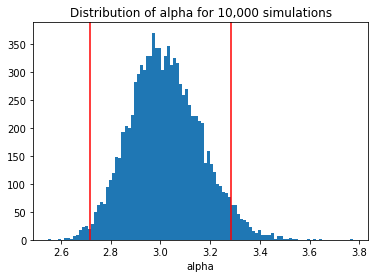

In [4]:
def get_alpha_cont(select_df):
  """ gets alpha paramter for continuous power law distribution
  """
  n = select_df.shape[0]
  xmin = select_df['diff'][0]
  a = 1 + n / np.sum(np.log(select_df['diff']/xmin))
  return a

def get_a_range(a, N):
  """ gets 95% confidence interval on alpha paramter estimate
  @param a: alpha
  @param N: number of samples in power law distribution
  @returns a_lower, a_upper: lower and upper bound on alpha 95% CI
  """
  stdev = (a-1)/np.sqrt(N)
  a_lower, a_upper = ((a-stdev*2), (a+stdev*2))
  return a_lower, a_upper

# show the get_a_range function is correct
N=200
a=3
alphas = []
for i in range(10000):
  # generate continuous power law data
  r = np.random.uniform(0,1,N)
  x1 = np.sort((1 - r) ** (-1 / (a - 1)))
  select_df = pd.DataFrame(data=x1, columns=['diff'])
  alphas.append(get_alpha_cont(select_df).astype(float))
alphas = np.sort(np.array(alphas))
plt.hist(alphas,bins=100)
plt.title("Distribution of alpha for 10,000 simulations")
plt.xlabel("alpha")
a_lower, a_upper = get_a_range(a, N)
plt.axvline(x=a_lower, ymin=0, ymax=350, c = "red")
plt.axvline(x=a_upper, ymin=0, ymax=350, c = "red")
print("a_lower = %s a_upper = %s" % (a_lower.round(3), a_upper.round(3)))
plt.show()

In [5]:
# for a stock, calculate xmin, alpha, KS stat and determine whether power law
def calc_emperical(df_sorted):
  """ determines whether a power law fits the dataset
  @param df_sorted: price change dataframe sorted from most frequent to least frequent
  @returns p: p-value of fit for power law. p < .1 indicates not a power law.
  p-value above .1 indicates either power law (could exponential or lognormal if N<200)
  """
  # get quantile, alpha, and KS for best fit
  q, a, KS, xmin = get_xmin(df_sorted)
  print("True q: %s a: %s KS: %s xmin: %s" % (q,a,KS,xmin))
  p = calc_fit(df_sorted, q, a, KS, xmin)
  print("p: ",p)
  return p

def calc_fit(df_sorted, q, a, KS, xmin):
  """ determines whether dataset fits power law
  @param df_sorted: price change dataframe sorted from most frequent to least frequent
  @param q: quantile for karmatta point
  @param a: alpha of dataset
  @param KS: Kolgoromov Smirnoff statistic for fit
  @param xmin: minimum x-value for power law data determined by get_xmin()
  @returns p: p-value of fit explained in calc_empirical doc 
  """
  KS_stats = []
  for i in range(500):
    df = generate_dataset(df_sorted,q,a,xmin)
    q_local, a_local, KS_local, xminlocal = get_xmin(df)
    KS_stats.append(KS_local)
  KS_stats=np.array(KS_stats)
  p = np.mean(KS_stats > KS)
  return p

def generate_dataset(df_sorted,q,a,xmin):
  """ generates synthetic dataset with q,a,xmin
  @returns df: synthetic dataset frame
  """
  N = df_sorted.shape[0]
  df_below_xmin = df_sorted.loc[df_sorted['prob'] >= q]
  # number of samples to generate from power law
  n_power = np.sum(np.random.uniform(0,1,N)<q)
  # number of samples to bootstrap from original dataset > q
  n_normal = N - n_power
  # generate power law variables
  r = np.random.uniform(0,1,n_power)
  x1 = xmin * (1 - r) ** (-1 / (a - 1))
  # bootstrap n_normal variables from df_below_xmin
  x2 = np.random.choice(df_below_xmin['diff'], n_normal, replace=True)
  # make new dataframe
  df = df_sorted.drop(['diff'], axis=1)
  df['diff'] = list(np.sort(np.concatenate((x1,x2),axis=0)))
  return df

def get_xmin(df_sorted):
  """ finds xmin value, quantile, alpha, and KS-stat for emperical distribution.
  @param df_sorted: df sorted by quantile, either negative or positive changes
  @return: quantile, alpha param, KS-stat, xmin
  """
  quants = [.2, .14, .10, .07, .035] # 100% of data - min quantile
  D, alphas1 = calc_KS(df_sorted, quants)
  sorted = list(np.argsort(D))
  num_searches = 6 # number of searches over smaller range
  # get quantiles of refined search range
  quants = list(np.linspace(quants[sorted[0]]-.025, quants[sorted[0]]+.025, num = num_searches))
  D2, alphas2 = calc_KS(df_sorted, quants)
  index = np.argmin(D2)
  # get quantile of best KS stat
  quant = np.round(quants[index], 3)
  # get alpha of that quantile
  alpha = alphas2[index]
  # get KS of that quantile
  KS = D2[index]
  # get minimum change in power law
  xmin = df_sorted['diff'].loc[df_sorted['prob'] < quant].iloc[0]
  return quant, alpha, KS, xmin

def calc_KS(df_sorted, quantiles):
  """ Calculate Kolmogorov-Smirnov Statistic for goodness of fit test using 
  CDF for continuous power law
  @param df_sorted: sorted dataframe
  @param quantiles: quantiles to test in df_sorted
  @return D: Distances measured by KS-stat
  @return alphas: alpha parameters corresponding to D[i] quantiles 
  """
  D = []
  alphas = []
  for i in range(len(quantiles)):
    # get subset for min quantile
    df = df_sorted.loc[df_sorted['prob'] < quantiles[i]]
    a = get_alpha_cont(df) # get alpha for that subset
    alphas.append(a)
    # calculate emperical cdf for subset
    df['emp_cdf'] = 1 - np.arange(df.shape[0])/df.shape[0]
    # get real cdf for continuous power law
    xmin = df['diff'].iloc[0]
    df['true_cdf'] = (df['diff']/xmin)**(-a + 1)
    # get KS Statistic on subset
    D.append(np.max(np.abs(df['emp_cdf'] - df['true_cdf'])/np.sqrt(df['true_cdf']*(1 - df['true_cdf']))))
  return D, alphas

In [6]:
pd.options.mode.chained_assignment = None
stock = yf.Ticker('TSLA')
df = stock.history(start = '2010-01-01', end = '2020-07-30', interval='1d')

# get daily log changes
df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
df_neg = np.abs(df.loc[df['diff'] < 0])

# sort by move size and calculate cdf
neg_sorted = df_neg.sort_values('diff')
neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]

calc_emperical(neg_sorted)

True q: 0.125 a: 3.421869780488113 KS: 0.1250897442631661 xmin: 0.04476998253839021
p:  0.664


0.664

In [7]:
# function to print power laws for stock
def show_power_law(ticker, direction, ax = None):
  """ prints graph of power law for price daily price changes in stock
  @param ticker: str of stock ticker symbol
  @param direction: str - either "pos" "neg" or "both" 
  @param ax: matplotlib axes for the graph
  """
  if direction not in ["pos", "neg","both"]:
    raise SyntaxError("Direction parameter for show_power_law not valid")
  if ax is None:
    ax = plt.gca()
  stock = yf.Ticker(ticker)
  df = stock.history(start = '2010-01-01', end = '2020-08-04', interval='1d')

  # get daily log changes
  df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
  df_neg = np.abs(df.loc[df['diff'] < 0])
  df_pos = df.loc[df['diff'] >= 0]

  if (direction == "neg") or (direction == "both"):
    # sort by move size and calculate cdf
    neg_sorted = df_neg.sort_values('diff')
    neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]

    q, alpha_hat, KS, xmin = get_xmin(neg_sorted)

    select_df = neg_sorted.loc[neg_sorted['prob'] < q]
    size = select_df.shape[0]

    # neg sorted slope
    x = np.linspace(select_df['diff'][0], select_df['diff'][-1],num=50)
    k = select_df['prob'][0] * (x[0] ** (alpha_hat))
    y = k * (x ** (-alpha_hat))
  if (direction == "pos") or (direction == "both"):
    # now for positive changes
    pos_sorted = df_pos.sort_values('diff')
    pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]
    q, alpha_hat2, KS, xmin = get_xmin(pos_sorted)
    select_df = pos_sorted.loc[pos_sorted['prob'] < q]
    size2 = select_df.shape[0]

    x_pos = np.linspace(select_df['diff'][0], select_df['diff'][-1],num=50)
    k = select_df['prob'][0] * (x_pos[0] ** (alpha_hat2))
    y_pos = k * (x_pos ** (-alpha_hat2))

  if (direction == "neg") or (direction == "both"):
    ax.plot(neg_sorted['diff'], neg_sorted['prob'], '.', c='red', markeredgecolor='none')
    ax.plot(x,y)
  if (direction == "pos") or (direction == "both"):
    ax.plot(pos_sorted['diff'], pos_sorted['prob'], '.', c='blue', markeredgecolor='none')
    ax.plot(x_pos, y_pos)
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_xlim(left = 10**-3)
  ax.set_title(ticker.upper())
  if (direction == "neg") or (direction == "both"):
    sigma_a = get_a_range(alpha_hat,size)
    print("neg alpha range:",sigma_a)
    textstr = r'$\alpha_-$ = %s %sN=%s' % (np.round(alpha_hat, 2),'\n',size)
    ax.annotate(textstr, xy=(x[0], y[0]), xytext=(x[0]+.02, y[0]+.3),
            arrowprops=dict(facecolor='black', shrink=0.1))
  if (direction == "pos") or (direction == "both"):
    sigma_a = get_a_range(alpha_hat2,size2)
    print("pos alpha range:",sigma_a)
    textstr2 = r'$\alpha_+$ = %s %sN=%s' % (np.round(alpha_hat2, 2),'\n',size2)
    ax.annotate(textstr2, xy=(x_pos[0], y_pos[0]), xytext=(x_pos[0], y_pos[0]+.3),
              arrowprops=dict(facecolor='black', shrink=0.1))
  return ax

pos alpha range: (3.220268272107018, 3.893143915246449)


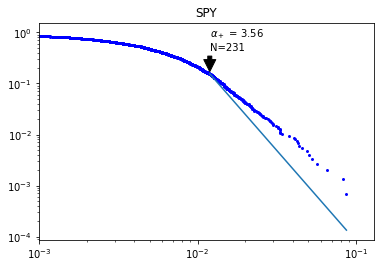

In [8]:
show_power_law('SPY','pos')

To get a cursory view of the distribution of daily returns for different stocks we look at the S&P 500. We import the tickers for the S&P in 2017 to avoid selection bias.

In [9]:
sp500 = pd.read_csv('./sp500-2017.csv')
sp500.head()

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology


In [64]:
#select group of stocks
sample_size = 6
group = random.sample(list(sp500['Symbol']), sample_size)

neg alpha range: (2.7160103803678672, 3.1906338539506423)
neg alpha range: (3.356882800664532, 4.760249106279015)
neg alpha range: (2.638101843390497, 3.4279643688649495)
neg alpha range: (3.117405635877063, 4.1444061338632725)
neg alpha range: (2.7335969111798573, 3.67310997637596)
neg alpha range: (3.365603868324244, 4.506254465383186)


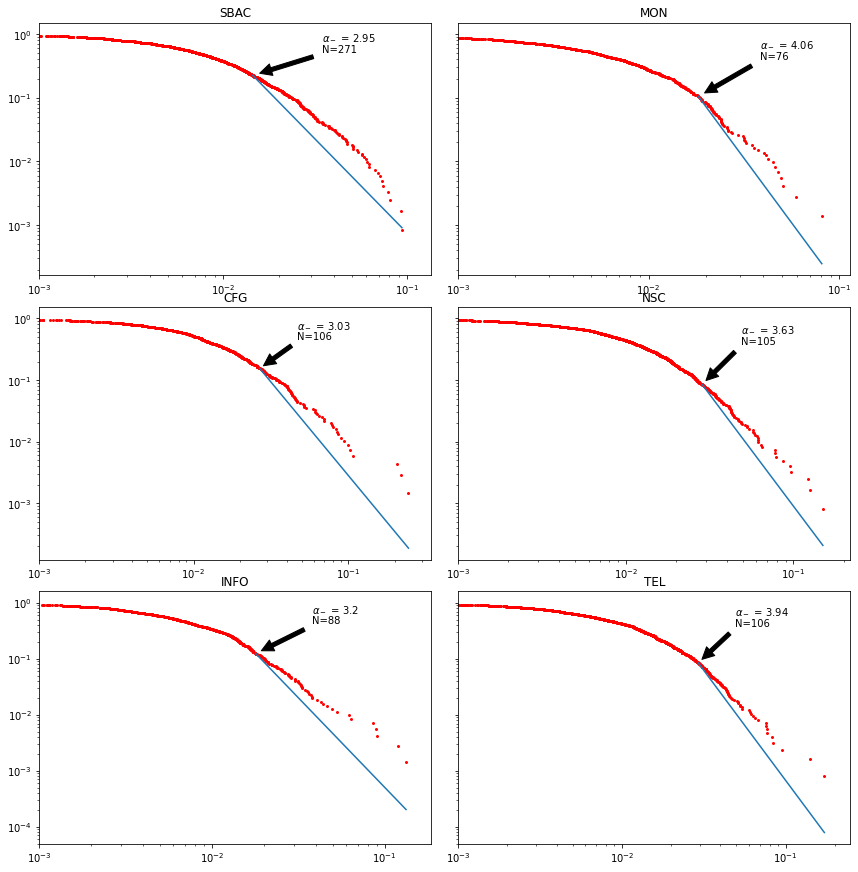

In [65]:
pd.options.mode.chained_assignment = None
fig, ax = plt.subplots(sample_size//2,2,sharey='row')
fig.set_figheight(sample_size*2)
fig.set_figwidth(12)
fig.tight_layout()
for i, symbol in enumerate(group):
  r = i // 2
  c = i % 2
  show_power_law(symbol, "neg", ax[r,c])

Now we value options using the alpha parameter caluclated above and relative pricing equations on pages 384 and 387 of Nassim Taleb's Statistical Consequences of Fat Tails.

In [81]:
def get_index(stock, S0, contract):
  """gets index of most liquid contract with expiration in 50-100 days
     @param stock: ticker output from yf.Ticker()
     @param S0: current stock price as of yesterday's close
     @param contract: "put" or "call" indicates contract type
     """
  expire_index = 0
  days_till_exp = 0
  max_liquid = 0
  for i in range(len(stock.options)):
    d = datetime.strptime(stock.options[i], '%Y-%m-%d')
    d = d.date() - datetime.today().date()
    d = str(d).split()[0]
    if d == '0:00:00':
      continue
    # variable tracks the max number of liquid contracts in range
    if float(d) > 50 and float(d) < 100:
      if contract == "put":
        # select contract with most liquidity in puts
        df = pd.DataFrame(stock.option_chain(stock.options[i]).puts)
        df = df.loc[(df['ask'] > 0) & (df['strike'] < S0)]
      elif contract == "call":
        # select contract with most liquidity in calls
        df = pd.DataFrame(stock.option_chain(stock.options[i]).calls)
        df = df.loc[(df['ask'] > 0) & (df['strike'] > S0)]
      else:
        raise SyntaxError("Indicate contract type in get_index function call")
      # evaluate number of liquid contracts
      s = df.shape[0]
      if s > max_liquid:
        max_liquid = s
        expire_index = i
        days_till_exp = str(d).split(" ")[0]
    elif float(d) >= 100:
      break
  now = datetime.now() + timedelta(days = int(days_till_exp))
  strike_date = '{:02d}-{:02d}-{:02d}'.format(now.year, now.month, now.day)
  print("Days till exp: ", days_till_exp, "Strike Date:",strike_date)
  if max_liquid == 0:
    raise ValueError("No liquid contracts for this time frame")
  return expire_index, int(days_till_exp)

def get_k1_call(expire_index, stock, S0, xmin, stdev, days_till_exp):
  """ gets best strike price near Karmatta Point for call
  @param expire_index: output of get_index()
  @param stock: output of yf.Ticker()
  @param S0: current price as of yesterday's close
  @param xmin: minimum daily percent change where power law applies
  @param stdev: standard deviation of daily movements in stock
  @param days_till_exp: days till expiration of option contract
  """
  df = pd.DataFrame(stock.option_chain(stock.options[expire_index]).calls)
  df = df.loc[df['ask'] > 0]
  # trading days or calandar days? Chose calandar for now
  stdev = np.sqrt((stdev**2)*days_till_exp) # stdev of option at expiration
  karmatta = 2 * stdev
  # get subset around the karmatta point
  subset = df.loc[(df['strike'] > S0*(1+karmatta*.9)) & (df['strike'] < S0*(1+karmatta*1.1))]
  # pick contract with smallest spread as it's maybe priced most efficiently
  return subset.iloc[[np.argmin(subset['ask'] - subset['bid'])]]

def get_k1_put(expire_index, stock, S0, xmin, stdev, days_till_exp):
  """ gets best strike price near Karmatta Point for put
  @param expire_index: output of get_index()
  @param stock: output of yf.Ticker()
  @param S0: current price as of yesterday's close
  @param xmin: minimum percent change where power law applies
  @param stdev: standard deviation of daily movements in stock
  @param days_till_exp: days till expiration of option contract
  """
  df = pd.DataFrame(stock.option_chain(stock.options[expire_index]).puts)
  df = df.loc[df['ask'] > 0]
  # get max of karmatta point and 2 stdev for options pricing point
  karmatta = stdev * np.sqrt(days_till_exp)
  # get subset around karmatta point
  subset = df.loc[(df['strike'] < S0*(1-karmatta*.9)) & (df['strike'] > S0*(1-karmatta*1.1))]
  # pick contract with smallest spread as it's maybe priced most efficiently
  return subset.iloc[[np.argmin(subset['ask'] - subset['bid'])]]

In [78]:
# check current pricing of calls vs market for stock
def check_calls(symbol, start = '2010-01-01', interval='1d'):
  # get todays date
  now = datetime.now()
  today = '{:02d}-{:02d}-{:02d}'.format(now.year, now.month, now.day)

  stock = yf.Ticker(symbol)
  df = stock.history(start=start, end=today, interval=interval)
  # get last price
  S0 = float(df.iloc[-1]['Close'])
  print("Current Price:",S0)

  # get positive daily log changes
  df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
  df_pos = df.loc[df['diff'] >= 0]

  # sort by move size and calculate cdf
  pos_sorted = df_pos.sort_values('diff')
  pos_sorted['prob'] = 1 - np.arange(pos_sorted.shape[0]) / pos_sorted.shape[0]

  q, a, KS, xmin = get_xmin(pos_sorted)
  
  # standard deviation of daily movements in stock
  stdev = np.sqrt(np.mean(df['diff']**2) - np.mean(df['diff'])**2)
  print("Standard Deviation:",stdev.round(4))

  ind, days_till_exp = get_index(stock, S0, "call")
  k1_df = get_k1_call(ind, stock, S0, xmin, stdev, days_till_exp)
  PK1 = float(k1_df['ask'])
  K1 = float(k1_df['strike'])
  print("Strike Price:",K1)

  # get option table for those above K1
  above_k1_df = pd.DataFrame(stock.option_chain(stock.options[ind]).calls)
  above_k1_df = above_k1_df.loc[above_k1_df['strike'] >= K1]
  # convert to float type
  above_k1_df['strike'] = above_k1_df['strike'].astype(float)
  # calculate value for each point above K1 using Nassim's formula for calls
  above_k1_df['model_value'] = PK1 * ((above_k1_df['strike'] - S0)/(K1 - S0))**(1-a)
  return above_k1_df

Current Price: 334.33
Standard Deviation: 0.011
Days till exp:  70 Strike Date: 2020-10-16
Strike Price: 390.0


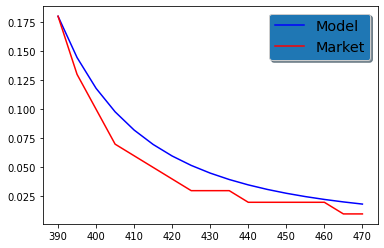

In [83]:
d = check_calls('SPY')
fig, ax = plt.subplots()
ax.plot(d['strike'], d['model_value'], c="blue", label='Model')
ax.plot(d['strike'], d['ask'],c="red", label='Market')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
plt.show()

In [80]:
def check_puts(symbol,start = '2010-01-01', interval='1d'):
  # get todays date
  now = datetime.now()
  today = '{:02d}-{:02d}-{:02d}'.format(now.year, now.month, now.day)

  stock = yf.Ticker(symbol)
  df = stock.history(start=start, end=today, interval=interval)
  # get last price
  S0 = float(df.iloc[-1]['Close'])
  print("Current Price:",S0)

  # get daily log changes
  df['diff'] = np.log(df['Close'].div((df['Close'].shift(1))))
  df_neg = np.abs(df.loc[df['diff'] < 0])

  # sort by move size and calculate cdf
  neg_sorted = df_neg.sort_values('diff')
  neg_sorted['prob'] = 1 - np.arange(neg_sorted.shape[0]) / neg_sorted.shape[0]

  q, a, KS, xmin = get_xmin(neg_sorted)
  
  # get standard deviation of negative movements
  stdev = np.sqrt(np.mean(df['diff']**2) - np.mean(df['diff'])**2)
  print("Standard Deviation:", stdev)

  # get K1 df (reference option price at karmatta point)
  ind, days_till_exp = get_index(stock, S0, "put")
  k1_df = get_k1_put(ind, stock, S0, xmin, stdev, days_till_exp)
  PK1 = float(k1_df['lastPrice'])
  K1 = float(k1_df['strike'])
  print("Strike Price:",K1)

  # get option table for those above K1
  below_k1_df = pd.DataFrame(stock.option_chain(stock.options[ind]).puts)
  below_k1_df = below_k1_df.loc[below_k1_df['strike'] < K1]
  below_k1_df['strike'] = below_k1_df['strike'].astype(float)

  # calculate put price using Nassim's Formula
  num = ((-1)**(1-a)*(S0**(-a))*((a-1)*below_k1_df[['strike']] + S0) - 
          (below_k1_df[['strike']].astype(complex) - S0)**(1-a))
  denom = ((-1)**(1-a)*S0**(-a)*((a-1)*K1 + S0)) - (K1 - S0)**(1-a)
  below_k1_df['model_value'] = PK1 * num / denom
  return below_k1_df

Current Price: 334.33
Standard Deviation: 0.010908151733504184
Days till exp:  70 Strike Date: 2020-10-16
Strike Price: 301.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


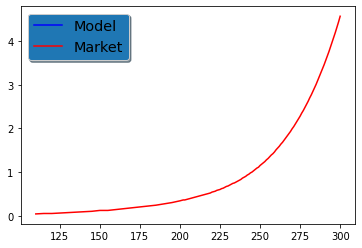

In [84]:
d = check_puts('SPY')
fig, ax = plt.subplots()
ax.plot(d['strike'], d['model_value'], c="blue", label='Model')
ax.plot(d['strike'], d['ask'],c="red", label='Market')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
plt.show()

In [ ]:
# NOTE: this is for discrete power laws
# def get_alpha(select_df):
#   #print("select_df: ", select_df)
#   xmin = select_df['diff'][0]
#   t1 = -np.sum(np.log(select_df['diff']/xmin)) / select_df.shape[0]

#   def log_zeta(x):
#     return np.log(zeta(x,1))

#   def log_deriv_zeta(x):
#     h=1e-5
#     return (log_zeta(x+h) - log_zeta(x-h))/(2*h)

#   def objective(x, t=t1):
#     return log_deriv_zeta(x) - t

#   return bisect(objective, 1.01, 10, xtol = 1e-6)

In [22]:
now = datetime.now()
today = '{:02d}-{:02d}-{:02d}'.format(now.year, now.month, now.day)


'2020-08-07'